In [13]:
import pebbles
import healpy as hp
import numpy as np
import pymaster as nmt
import matplotlib.pyplot as plt
import pysm
plt.style.use('supermongo')
%matplotlib inline

def setup_run():
    """ Function to deal with the arguments passed to the script.
    """
    arp = argparse.ArgumentParser()
    arp.add_argument('configuration', type=str)
    arp.add_argument('-nside', type=int, default=256)
    arp.add_argument('-nmc', type=int, default=200)
    args = arp.parse_args()
    # this function combines all the lists of settings for each option to
    # produce an iterable over all the combinations of settings to be run.
    print(args.configuration)
    jobs = pebbles.read_config_file(args.configuration)
    # if running in a parallel environment set the cpu count.
    os.environ['OMP_NUM_THREADS'] = str(multiprocessing.cpu_count())
    confname = os.path.basename(args.configuration)[:-5]
    return args.nside, args.nmc, jobs, confname

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


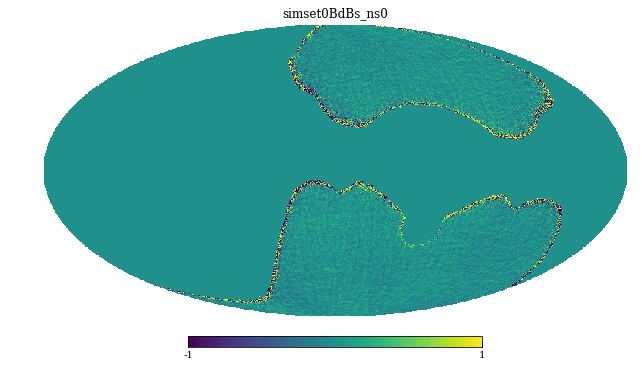

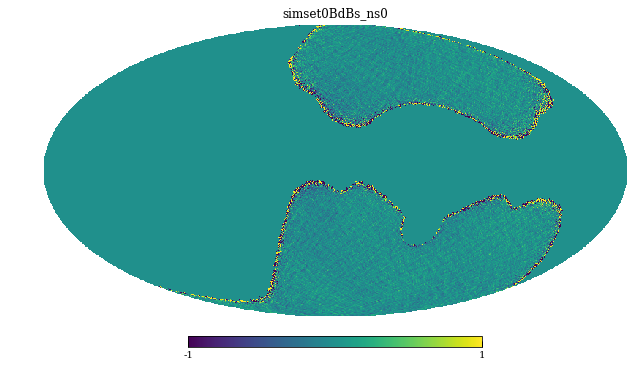

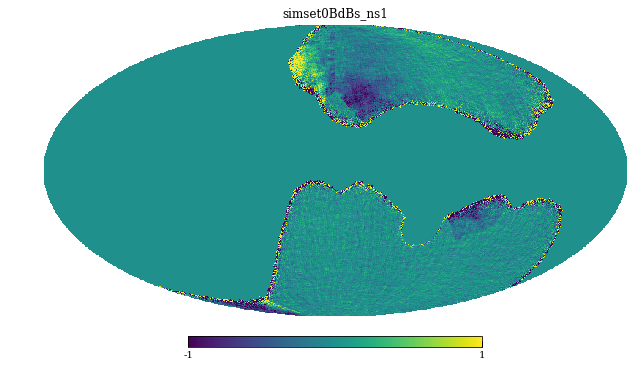

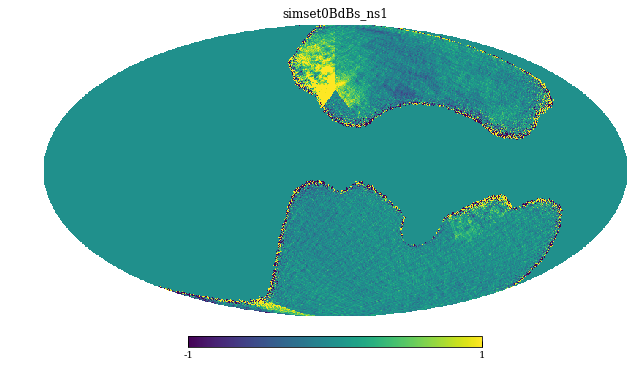

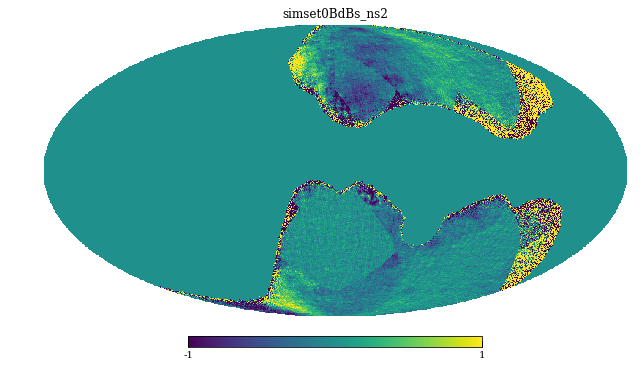

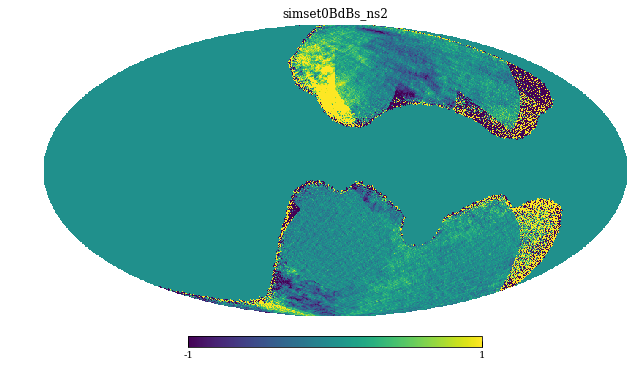

In [18]:
jobs = pebbles.read_config_file("/global/homes/b/bthorne/Projects/simonsobs/mapspace/src/configurations/simset0_healpix_pix.yml")
nside = 256
nmc = 200
# Plot a comparison of the power spectra.
x_data = []
y_bias = []
y_std = []
for sim, cos, ins, fit, pwr, lkl in jobs('SIMSETS', 'COSMOLOGIES', 'INSTRUMENTS',
                                            'FITTING_MODELS', 'POWERS', 'LIKELIHOODS'):
    peb = pebbles.Pebbles(nside, sim, cos, ins, nmc=nmc)
    cmb = peb.load_stacked_cleaned_amp_maps(fit, 'cmb')
    hp.mollview(cmb[0], title=sim+fit, min=-1, max=1)
    hp.mollview(cmb[1], title=sim+fit, min=-1, max=1)

In [16]:
d1 = pysm.nominal.models('d1', nside)[0]
d1q = d1['A_Q']
d1u = d1['A_U']
d1q_mask = pebbles.plotting.apply_so_mask(d1q)
d1u_mask = pebbles.plotting.apply_so_mask(d1u)

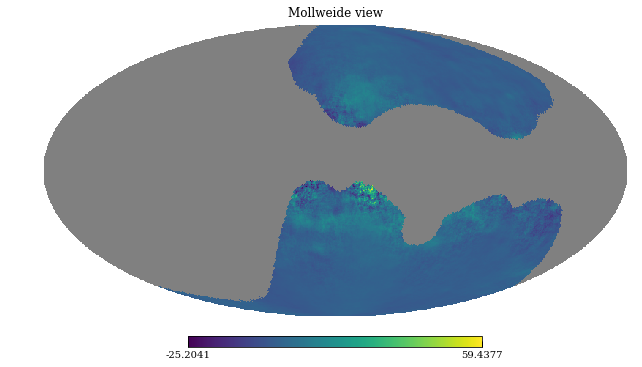

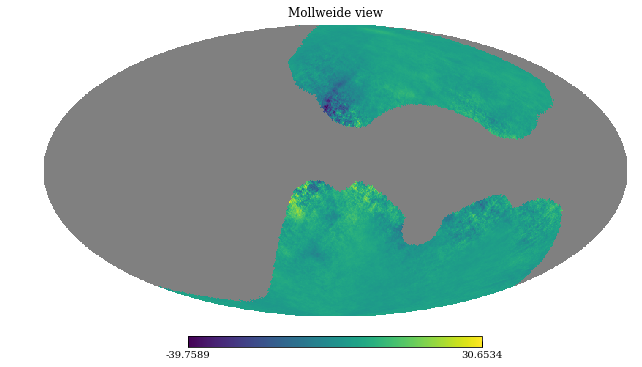

In [17]:
hp.mollview(d1q_mask)
hp.mollview(d1u_mask)

In [18]:
s1 = pysm.nominal.models('s1', nside)[0]
s1q = s1['A_Q']
s1u = s1['A_U']
s1q_mask = pebbles.plotting.apply_so_mask(s1q)
s1u_mask = pebbles.plotting.apply_so_mask(s1u)

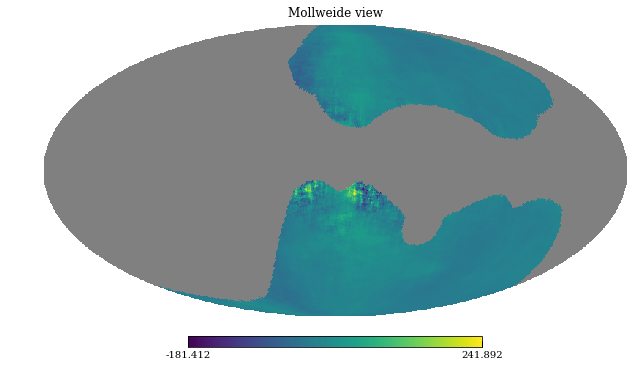

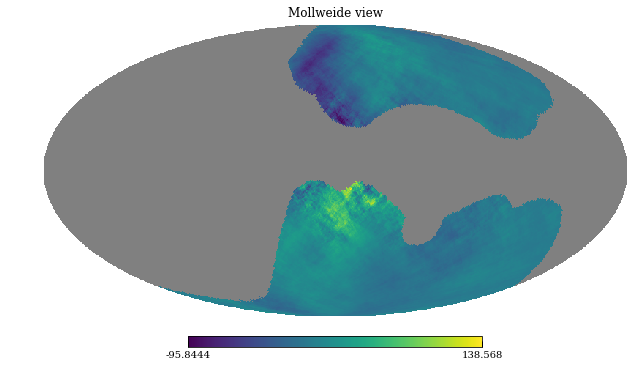

In [19]:
hp.mollview(s1q_mask)
hp.mollview(s1u_mask)

In [20]:
#mask = pebbles.configurations.masking.so_mask_hits(nside, aposcale=25)
mask = pebbles.configurations.masking.so_mask_fitting(nside)
mask = nmt.mask_apodization(mask, 20, 'C2')

In [21]:
s = nmt.NmtField(mask, [s1q, s1u], purify_b=True)
d = nmt.NmtField(mask, [d1q, d1u], purify_b=True)
cmb_cont = nmt.NmtField(mask, cmb, purify_b=True)
cmb_clean = nmt.NmtField(mask, cmb, purify_b=True, templates=[[d1q, d1u]])

In [19]:
vmin = -0.3
vmax = 0.3
hp.mollview(cmb_cont.get_maps()[0], min=vmin, max=vmax)
hp.mollview(cmb_clean.get_maps()[0], min=vmin, max=vmax)
hp.mollview(cmb_cont.get_maps()[0] - cmb_clean.get_maps()[0], min=0.1 * vmin, max=0.1 * vmax)

NameError: name 'cmb_cont' is not defined

In [23]:
nmtbin = nmt.NmtBin(nside, nlb=10)
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(s, cmb_cont, nmtbin)

sc_cl_cont = nmt.compute_coupled_cell(s, cmb_cont)
dc_cl_cont = nmt.compute_coupled_cell(d, cmb_cont)
sc_cl_clean = nmt.compute_coupled_cell(s, cmb_clean)
dc_cl_clean = nmt.compute_coupled_cell(d, cmb_clean)

sc_cl_decouple_cont = wsp.decouple_cell(sc_cl_cont)
dc_cl_decouple_cont = wsp.decouple_cell(dc_cl_cont)
sc_cl_decouple_clean = wsp.decouple_cell(sc_cl_clean)
dc_cl_decouple_clean = wsp.decouple_cell(dc_cl_clean)

/global/homes/b/bthorne/anaconda3/envs/pebbles/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


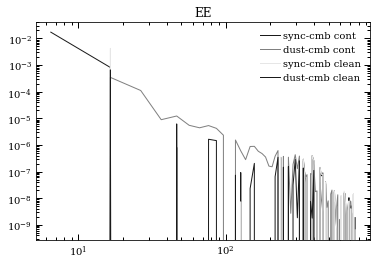

In [24]:
ellb = nmtbin.get_effective_ells()
fig, ax = plt.subplots(1, 1)
ax.set_title("EE")
ax.loglog(ellb, sc_cl_decouple_cont[0], label='sync-cmb cont')
ax.loglog(ellb, dc_cl_decouple_cont[0], label='dust-cmb cont')
ax.loglog(ellb, sc_cl_decouple_clean[0], label='sync-cmb clean')
ax.loglog(ellb, dc_cl_decouple_clean[0], label='dust-cmb clean')
ax.legend()

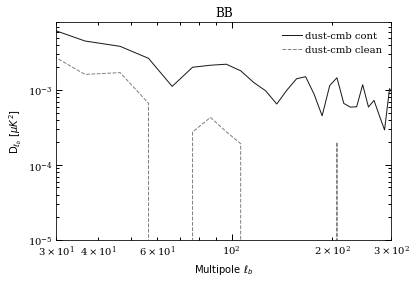

In [25]:
ellb = nmtbin.get_effective_ells()
dlb = ellb * (ellb + 1) / 2. / np.pi
fig, ax = plt.subplots(1, 1)
ax.set_ylabel(r'$\mathcal{D}_{\ell_b} \ [\mu K^2]$')
ax.set_xlabel(r'${\rm Multipole} \ \ell_b$')
ax.set_title("BB")
#ax.loglog(ellb, dlb * sc_cl_decouple_cont[3], label='sync-cmb cont')
ax.loglog(ellb, dlb * dc_cl_decouple_cont[3], label='dust-cmb cont')
#ax.loglog(ellb, dlb * sc_cl_decouple_clean[3], label='sync-cmb clean')
ax.loglog(ellb, dlb * dc_cl_decouple_clean[3], label='dust-cmb clean', linestyle='--')
ax.set_xlim(30, 300)
ax.set_ylim(1e-5, 8e-3)
ax.legend()

In [26]:
scl = nmt.compute_full_master(s, cmb, nmtbin)

AttributeError: 'numpy.ndarray' object has no attribute 'fl'

In [ ]:
for sim, cos, ins, fit, pwr, lkl in jobs('SIMSETS', 'COSMOLOGIES', 'INSTRUMENTS',
                                            'FITTING_MODELS', 'POWERS', 'LIKELIHOODS'):
    peb = pebbles.Pebbles(nside, sim, cos, ins, nmc=nmc)
    betas = peb.load_cleaned_spec_maps(fit, 0)
    betad = peb.load_cleaned_spec_maps(fit, 1)

In [ ]:
hp.mollview(cmb, min=-3.2, max=-2.7)
print(np.unique(cmb))

In [ ]:
beta= pysm.nominal.models('s1', nside)[0]['spectral_index']

In [ ]:
ind = pebbles.configurations.fittingmodels.mamd8_binned(nside)

In [ ]:
hp.mollview(ind)

In [ ]:
theory = np.zeros_like(ind)

In [ ]:
theory[ind==0] = np.mean(beta[ind==0])
theory[ind==1] = np.mean(beta[ind==1])
theory[ind==2] = np.mean(beta[ind==2])

In [ ]:
hp.mollview(theory, min=-3.2, max=-2.7)
hp.mollview(cmb, min=-3.2, max=-2.7)

In [ ]:
print(np.unique(theory))
print(np.unique(cmb))

In [ ]:
beta_d = pysm.nominal.models('d1', nside)[0]['spectral_index']

In [ ]:
theoryd = np.zeros_like(beta_d)
theoryd[ind==0] = np.mean(beta_d[ind==0])
theoryd[ind==1] = np.mean(beta_d[ind==1])
theoryd[ind==2] = np.mean(beta_d[ind==2])

In [ ]:
hp.mollview(theoryd, min=1.53, max=1.55)
hp.mollview(betad, min=1.5)


In [ ]:
print(np.unique(betad))
print(np.unique(theoryd))

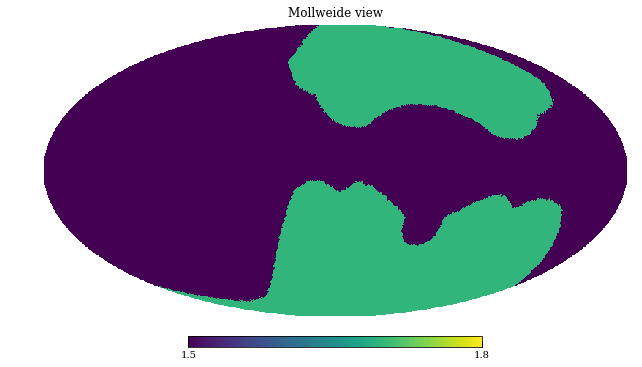

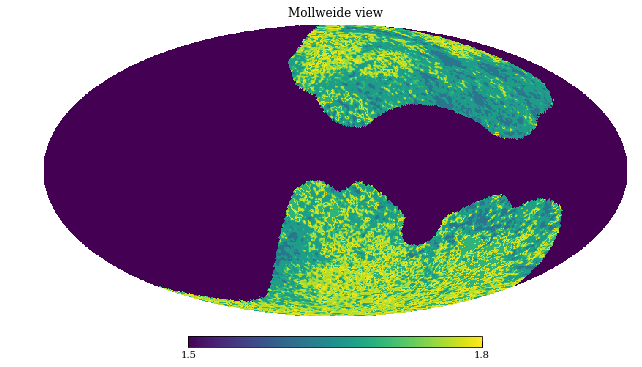

In [10]:
for sim, cos, ins, fit, pwr, lkl in jobs('SIMSETS', 'COSMOLOGIES', 'INSTRUMENTS',
                                            'FITTING_MODELS', 'POWERS', 'LIKELIHOODS'):
    peb = pebbles.Pebbles(nside, sim, cos, ins, nmc=nmc)
    
    beta = peb.load_cleaned_spec_maps(fit, 1)
    hp.mollview(beta, min=1.5, max=1.8)

In [11]:
print(np.unique(beta))

[0.         1.61799979 1.66067719 1.66340709 1.66741109 1.66947258
 1.6917063  1.69494164 1.70873737 1.75092053 1.76815212 1.76969516
 1.79178905]
